In [ ]:
import pandas as pd

In [ ]:
data['%Change'] = (data['Open'].pct_change() * 100).fillna(0)

# Categorise percentage change into ranges
def categorise_change(percentage_change):
    if percentage_change > 10:
        return 4
    elif percentage_change > 5:
        return 3
    elif percentage_change > 0:
        return 2
    elif percentage_change > -5:
        return 1
    else:
        return 0
def binary_cat(val):
    if val > 0:
      return 1
    return 0
data['ChgCat'] = data['%Change'].apply(lambda x: categorise_change(x))
data['Binary'] = data['%Change'].apply(lambda x: binary_cat(x))
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,%Change,ChgCat,Binary
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400,0.000000,1,0
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200,-4.782608,1,0
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000,-7.305938,0,0
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400,1.970442,2,1
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400,2.898553,2,1


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
data = data.drop(columns = ['Date'],axis = 1)
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

numerical_cols = ['Open','Close','High','Low','Volume']
scaler = MinMaxScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

encoder = LabelEncoder()
data['Cat_encoded'] = encoder.fit_transform(data['ChgCat'])

X_train, X_val, y_train, y_val = train_test_split(
    data[['Open','Close','High','Low','Volume']], data["Cat_encoded"], test_size=0.2, random_state=1000
)
X_train

,Open,Close,High,Low,Volume
177,0.321608,0.325,0.325,0.325,0.046788
197,0.135678,0.130,0.135,0.130,0.065485
418,0.085427,0.090,0.090,0.090,0.141377
132,0.743719,0.745,0.750,0.745,0.023370
33,0.698493,0.690,0.695,0.690,0.090397
...,...,...,...,...,...
251,0.311558,0.310,0.315,0.310,0.154725
192,0.266332,0.270,0.270,0.270,0.047656
71,0.587940,0.585,0.585,0.585,0.017443
87,0.587940,0.590,0.590,0.590,0.067075


In [ ]:
class CustomLSTM:
    def __init__(self, input_size, hidden_size, learning_rate=0.001):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        # Parameters initialization
        self.W_f = np.random.randn(hidden_size, input_size + hidden_size)  # Forget gate
        self.b_f = np.zeros((hidden_size, 1))

        self.W_i = np.random.randn(hidden_size, input_size + hidden_size)  # Input gate
        self.b_i = np.zeros((hidden_size, 1))

        self.W_c = np.random.randn(hidden_size, input_size + hidden_size)  # Cell state
        self.b_c = np.zeros((hidden_size, 1))

        self.W_o = np.random.randn(hidden_size, input_size + hidden_size)  # Output gate
        self.b_o = np.zeros((hidden_size, 1))

        # Cell state initialization
        self.c = np.zeros((hidden_size, 1))

        # Hidden state initialization
        self.h = np.zeros((hidden_size, 1))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def tanh(self, x):
        return np.tanh(x)

    def forward(self, x):
        # Adjust the dimensions of x
        if len(x.shape) == 2:
            x = x.reshape(-1, 1)
        #print(f'self.h is {self.h}')
        #print(f' x is {x.values}')
        concat_input = np.concatenate((self.h, np.array(x).reshape(len(x), 1)), axis=0)
        #print(f'shape of concat is {concat_input.shape}')
        # Forget gate
        self.f = self.sigmoid(np.dot(self.W_f, concat_input) + self.b_f)

        # Input gate
        self.i = self.sigmoid(np.dot(self.W_i, concat_input) + self.b_i)

        # Cell state
        self.c_bar = self.tanh(np.dot(self.W_c, concat_input) + self.b_c)
        self.c = self.f * self.c + self.i * self.c_bar

        # Output gate
        self.o = self.sigmoid(np.dot(self.W_o, concat_input) + self.b_o)

        # Hidden state
        self.h = self.o * self.tanh(self.c)

        return self.h, self.c

    def backward(self, x, dh_next, dc_next, d_next):
        # Compute gradients of loss w.r.t. LSTM parameters
        dW_f = np.zeros_like(self.W_f)
        db_f = np.zeros_like(self.b_f)
        dW_i = np.zeros_like(self.W_i)
        db_i = np.zeros_like(self.b_i)
        dW_c = np.zeros_like(self.W_c)
        db_c = np.zeros_like(self.b_c)
        dW_o = np.zeros_like(self.W_o)
        db_o = np.zeros_like(self.b_o)

        dh_prev = np.zeros_like(self.h)
        dc_prev = np.zeros_like(self.c)

        # Backpropagate through time
        for t in reversed(range(len(x))):
            concat_input = np.concatenate((self.h,np.array(x.reshape(-1, 1))), axis=0)
            # Gradient from next hidden state and next cell state

            d_concat = np.dot(self.W_f.T, d_next) + np.dot(self.W_i.T, d_next) + \
           np.dot(self.W_c.T, d_next) + np.dot(self.W_o.T, d_next)
            dh = d_concat[:self.hidden_size, :]
            #dc = dc_prev + d_concat[self.hidden_size:, :]
            dc = dc_prev + dh
            #dc = dc_prev + d_concat[self.hidden_size:, :].reshape(dc_prev.shape)
            # Gradient for output gate
            do = dh * self.tanh(self.c) * self.sigmoid(self.o) * (1 - self.sigmoid(self.o))
            dW_o += np.dot(do, d_concat.T)
            db_o += do

            # Gradient for cell state
            dc_bar = dc * self.i * (1 - self.c_bar ** 2)
            dW_c += np.dot(dc_bar, d_concat.T)
            db_c += dc_bar

            # Gradient for input gate
            di = dc * self.c_bar * self.sigmoid(self.i) * (1 - self.sigmoid(self.i))
            dW_i += np.dot(di, d_concat.T)
            db_i += di

            # Gradient for forget gate
            df = dc * self.c * self.sigmoid(self.f) * (1 - self.sigmoid(self.f))
            dW_f += np.dot(df, d_concat.T)
            db_f += df

            # Gradient for previous hidden state and cell state
            dh_prev = np.dot(self.W_f.T, df) + np.dot(self.W_i.T, di) + np.dot(self.W_c.T, dc_bar) + np.dot(self.W_o.T, do)
            dc_prev = dc * self.f

        # Update LSTM parameters
        self.W_f -= self.learning_rate * dW_f
        self.b_f -= self.learning_rate * db_f
        self.W_i -= self.learning_rate * dW_i
        self.b_i -= self.learning_rate * db_i
        self.W_c -= self.learning_rate * dW_c
        self.b_c -= self.learning_rate * db_c
        self.W_o -= self.learning_rate * dW_o
        self.b_o -= self.learning_rate * db_o

        return dh_prev, dc_prev
    def predict(self, X):
        # Initialize hidden state and cell state
        h_prev = np.zeros((self.hidden_size, 1))
        c_prev = np.zeros((self.hidden_size, 1))

        # Make predictions for each timestep in the input sequence
        predicted_classes = []
        for x in X:
            # Forward pass through LSTM cell
            h, c = self.forward(x)
            print(f'h is {h}')
            # Make prediction based on the current hidden state
            # Pass hidden state through a fully connected layer with softmax activation
            #output = np.dot(self.W_output, h) + self.b_output
            probabilities = softmax(h)  # Apply softmax activation

            # Predict the class with the highest probability
            predicted_class = np.argmax(probabilities)

            # Append the predicted class to the list of predicted classes
            predicted_classes.append(predicted_class)

        return predicted_classes



# Example usage
input_size = 5
hidden_size = 4

lstm = CustomLSTM(input_size, hidden_size)
for epoch in range(2):
    print(f'Progress: {epoch}%')
    epoch_loss = 0.0

    for t in range(len(X_train)):
        print(f'Internal Progress: Current epoch is {epoch}, {t/len(X_train) *100}%')
        # Forward pass
        h, c = lstm.forward(X_train.iloc[t])

        # Calculate loss for this time step
        loss = np.mean((h - y_train.iloc[t]) ** 2)
        epoch_loss += loss

        # Backward pass
        dh_next = np.zeros_like(h)
        dc_next = np.zeros_like(c)
        d_next = 2.0 * (h - y_train.iloc[t])  # Gradient of mean squared error loss
        lstm.backward(X_train[:t+1].values, dh_next, dc_next, d_next)


    # Print average loss for the epoch
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {epoch_loss / len(X_train)}')



Progress: 0%
Internal Progress: Current epoch is 0, 0.0%
Internal Progress: Current epoch is 0, 0.25%
Internal Progress: Current epoch is 0, 0.5%
Internal Progress: Current epoch is 0, 0.75%
Internal Progress: Current epoch is 0, 1.0%
Internal Progress: Current epoch is 0, 1.25%
Internal Progress: Current epoch is 0, 1.5%
Internal Progress: Current epoch is 0, 1.7500000000000002%
Internal Progress: Current epoch is 0, 2.0%
Internal Progress: Current epoch is 0, 2.25%
Internal Progress: Current epoch is 0, 2.5%
Internal Progress: Current epoch is 0, 2.75%
Internal Progress: Current epoch is 0, 3.0%
Internal Progress: Current epoch is 0, 3.25%
Internal Progress: Current epoch is 0, 3.5000000000000004%
Internal Progress: Current epoch is 0, 3.75%
Internal Progress: Current epoch is 0, 4.0%
Internal Progress: Current epoch is 0, 4.25%
Internal Progress: Current epoch is 0, 4.5%
Internal Progress: Current epoch is 0, 4.75%
Internal Progress: Current epoch is 0, 5.0%
Internal Progress: Curre

<ipython-input-147-6cdfee3ebf79>:27: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Internal Progress: Current epoch is 0, 14.249999999999998%
Internal Progress: Current epoch is 0, 14.499999999999998%
Internal Progress: Current epoch is 0, 14.75%
Internal Progress: Current epoch is 0, 15.0%
Internal Progress: Current epoch is 0, 15.25%
Internal Progress: Current epoch is 0, 15.5%
Internal Progress: Current epoch is 0, 15.75%
Internal Progress: Current epoch is 0, 16.0%
Internal Progress: Current epoch is 0, 16.25%
Internal Progress: Current epoch is 0, 16.5%
Internal Progress: Current epoch is 0, 16.75%
Internal Progress: Current epoch is 0, 17.0%
Internal Progress: Current epoch is 0, 17.25%
Internal Progress: Current epoch is 0, 17.5%
Internal Progress: Current epoch is 0, 17.75%
Internal Progress: Current epoch is 0, 18.0%
Internal Progress: Current epoch is 0, 18.25%
Internal Progress: Current epoch is 0, 18.5%
Internal Progress: Current epoch is 0, 18.75%
Internal Progress: Current epoch is 0, 19.0%
Internal Progress: Current epoch is 0, 19.25%
Internal Progress

AttributeError: 'str' object has no attribute 'shape'

In [ ]:
def softmax(x):
    exp_x = np.exp(x - np.max(x))  # Subtracting the maximum value for numerical stability
    return exp_x / np.sum(exp_x, axis=0)

In [ ]:
#predictions = lstm.predict(X_val)
for i in range(len(X_val)):
  print(X_val.iloc[i])
  #print(i)
  h_prev = np.zeros((4, 1))
  c_prev = np.zeros((4, 1))

  # Make predictions for each timestep in the input sequence
  predicted_classes = []
      # Forward pass through LSTM cell
  h, c = lstm.forward(X_val.iloc[i])
  print(c)
  #print(f'h.shape is {h.shape}')
  #print(f'lstm Wo is {lstm.W_o.shape}')
  #print(f' bo is {lstm.b_o.shape}')
      # Make prediction based on the current hidden state
      # Pass hidden state through a fully connected layer with softmax activation
  #output = np.dot(h.T,lstm.W_o).T + lstm.b_o
  probabilities = softmax(h)  # Apply softmax activation

      # Predict the class with the highest probability
predicted_class = np.argmax(probabilities)

      # Append the predicted class to the list of predicted classes
predicted_classes.append(predicted_class)

Open      0.271357
Close     0.275000
High      0.275000
Low       0.275000
Volume    0.139883
Name: 319, dtype: float64
[[nan]
 [nan]
 [nan]
 [nan]]
Open      0.301508
Close     0.305000
High      0.310000
Low       0.305000
Volume    0.108322
Name: 207, dtype: float64
[[nan]
 [nan]
 [nan]
 [nan]]
Open      0.809045
Close     0.810000
High      0.815000
Low       0.810000
Volume    0.021298
Name: 22, dtype: float64
[[nan]
 [nan]
 [nan]
 [nan]]
Open      0.080402
Close     0.085000
High      0.085000
Low       0.085000
Volume    0.046885
Name: 420, dtype: float64
[[nan]
 [nan]
 [nan]
 [nan]]
Open      0.206030
Close     0.210000
High      0.210000
Low       0.210000
Volume    0.173276
Name: 352, dtype: float64
[[nan]
 [nan]
 [nan]
 [nan]]
Open      0.698493
Close     0.715000
High      0.745000
Low       0.700000
Volume    0.181420
Name: 491, dtype: float64
[[nan]
 [nan]
 [nan]
 [nan]]
Open      0.432161
Close     0.425000
High      0.430000
Low       0.425000
Volume    0.055269
Name: 

In [ ]:
X_val.iloc[0].shape

(5,)

In [ ]:
predicted_class

0

#New Implementation with Pytorch Layers

In [ ]:
data2 = data.copy(deep = True).drop(columns = ['%Change','ChgCat','Binary'])
train = data2[:400]
test = data2[400:]
train

,Open,High,Low,Close,Adj Close,Volume,Cat_encoded
0,0.708543,0.710,0.710,0.710,0.406782,1.000000,1
1,0.653266,0.650,0.650,0.650,0.385558,0.369392,1
2,0.572864,0.570,0.570,0.570,0.357260,0.218474,0
3,0.592965,0.595,0.595,0.595,0.366103,0.176986,2
4,0.623116,0.625,0.625,0.625,0.376715,0.149039,2
...,...,...,...,...,...,...,...
395,0.010050,0.015,0.015,0.015,0.160944,0.267287,2
396,0.020100,0.025,0.025,0.025,0.164481,0.127403,2
397,0.050251,0.055,0.055,0.055,0.175093,0.237074,3
398,0.055276,0.065,0.060,0.060,0.176862,0.144027,2


In [ ]:
import torch
from torch import nn

class LSTM_cell(torch.nn.Module):
    def __init__(self, input_length=10, hidden_length=20):
        super(LSTM_cell, self).__init__()
        self.input_length = input_length
        self.hidden_length = hidden_length

        # forget gate components
        self.forget_w = nn.Linear(self.input_length, self.hidden_length, bias=True)
        self.forget_r = nn.Linear(self.hidden_length, self.hidden_length, bias=False)
        self.sigmoid_forget = nn.Sigmoid()

        # input gate components
        self.input_w = nn.Linear(self.input_length, self.hidden_length, bias=True)
        self.input_r = nn.Linear(self.hidden_length, self.hidden_length, bias=False)
        self.sigmoid_gate = nn.Sigmoid()

        # cell memory components
        self.memory_w = nn.Linear(self.input_length, self.hidden_length, bias=True)
        self.memory_r = nn.Linear(self.hidden_length, self.hidden_length, bias=False)
        self.activation_gate = nn.Tanh()

        # out gate components
        self.output_w = nn.Linear(self.input_length, self.hidden_length, bias=True)
        self.output_r = nn.Linear(self.hidden_length, self.hidden_length, bias=False)
        self.sigmoid_hidden_out = nn.Sigmoid()

        self.activation_final = nn.Tanh()

    def forget(self, x, h):
        x = self.forget_w(x)
        h = self.forget_r(h)
        return self.sigmoid_forget(x + h)

    def input_gate(self, x, h):

        x_temp = self.input_w(x)
        h_temp = self.input_r(h)
        i = self.sigmoid_gate(x_temp + h_temp)
        return i

    def cell_memory_gate(self, i, f, x, h, c_prev):
        x = self.memory_w(x)
        h = self.memory_r(h)

        # new information part that will be injected in the new context
        k = self.activation_gate(x + h)
        g = k * i

        # forget old context/cell info
        c = f * c_prev
        # learn new context/cell info
        c_next = g + c
        return c_next

    def out_gate(self, x, h):
        x = self.output_w(x)
        h = self.output_r(h)
        return self.sigmoid_hidden_out(x + h)

    # Forward function defining the flow of data through the LSTM cell
    def forward(self, x, tuple_in ):
        (h, c_prev) = tuple_in
        # Input Gate
        i = self.input_gate(x, h)

        # Forget Gate
        f = self.forget(x, h)

        # Update cell memory
        c_next = self.cell_memory_gate(i, f, x, h,c_prev)

        # Output Gate
        o = self.out_gate(x, h)

        # Hidden State Output
        h_next = o * self.activation_final(c_next)
        return h_next, c_next

In [ ]:
class Sequence(nn.Module):
    def __init__(self,no_classes = 5):
        super(Sequence, self).__init__()
        # # Define two LSTM cells with input and hidden lengths
        self.rnn1 = LSTM_cell(1, 5)
        self.rnn2 = LSTM_cell(5, 5)
        # Linear class for number of classes at the end
        self.linear = nn.Linear(5, no_classes)


    # Forward function defining the flow of data through the network
    def forward(self, input, future=0):
        outputs = []
        # Initialise hidden and cell states for both LSTM cells
        h_t = torch.zeros(input.size(0), 5, dtype=torch.double)
        c_t = torch.zeros(input.size(0), 5, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), 5, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), 5, dtype=torch.double)

        # Iterate through each time step of the input sequence
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.rnn1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.rnn2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]

        for i in range(future):
            h_t, c_t = self.rnn1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.rnn2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs


In [ ]:
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch
import torch.optim as optim
import torch.nn.functional as F

batch_size = 16
shuffle = True

# Create a data loader
train_features_tensor = torch.tensor(train[['Open','High','Low','Close','Volume','Adj Close']].values, dtype=torch.double)
train_labels_tensor = torch.tensor(train['Cat_encoded'].values, dtype=torch.double)



num_classes = 5
one_hot_labels = F.one_hot(train_labels_tensor.view(-1).long(), num_classes)
#train_labels_tensor = torch.unsqueeze(train_labels_tensor, dim=1)

# Create a TensorDataset
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)  # If you don't have labels, omit train_labels_tensor

# Loading Training Data
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

input_length = 5
hidden_length = 5
lstm_cell = LSTM_cell(input_length, hidden_length)

seq = Sequence()

seq.double()

#Initiatialising Cross Entropy Loss for Loss Function
criterion = nn.CrossEntropyLoss()

loss_history = []
optimizer = optim.LBFGS(seq.parameters(), lr=0.1)
# begin to train
for i in range(20):
  print('STEP: ', i)

  def closure():
      optimizer.zero_grad()
      out = seq(train_features_tensor)
      #print(f'out dimension {out.shape}')
      loss = criterion(out, one_hot_labels)
      loss_history.append(loss)
      print(f"loss: {loss.item()}")
      loss.backward()
      return loss

  optimizer.step(closure)

STEP:  0
Step: 0, loss: 1.807376254866498
Step: 0, loss: 1.8070407220674312
Step: 0, loss: 1.7981752010432286
Step: 0, loss: 1.7692629440705567
Step: 0, loss: 1.745480304837435
Step: 0, loss: 1.7249473661063706
Step: 0, loss: 1.6142775524024995
Step: 0, loss: 1.4266623215913548
Step: 0, loss: 1.1393545495576918
Step: 0, loss: 0.6772128350018373
Step: 0, loss: 0.6483418092098957
Step: 0, loss: 0.6314230988342167
Step: 0, loss: 0.6144530840496973
Step: 0, loss: 0.5974724843084658
Step: 0, loss: 0.5812444914335296
Step: 0, loss: 0.5668169421451925
Step: 0, loss: 0.5543773403605698
Step: 0, loss: 0.5431162557412894
Step: 0, loss: 0.5318166450959837
Step: 0, loss: 0.5192066169294935
STEP:  1
Step: 1, loss: 0.5053227841542446
Step: 1, loss: 0.49319930924138694
Step: 1, loss: 0.4818460344628218
Step: 1, loss: 0.4692017080933362
Step: 1, loss: 0.45376788326386136
Step: 1, loss: 0.43378426952879495
Step: 1, loss: 0.4160952671549602
Step: 1, loss: 0.40599530944188505
Step: 1, loss: 0.39581506860

In [ ]:
test_features_tensor = torch.tensor(test[['Open','High','Low','Close','Volume','Adj Close']].values, dtype=torch.double)
test_labels_tensor = torch.tensor(test['Cat_encoded'].values, dtype=torch.double)
num_classes = 5
one_hot_labels_test = F.one_hot(test_labels_tensor.view(-1).long(), num_classes)
with torch.no_grad():
      future = 5
      pred = seq(test_features_tensor, future=future)
      class_probs = torch.softmax(pred, dim=1)
      predicted_classes = torch.argmax(pred, dim=1)
      loss = criterion(pred[:, :-future], one_hot_labels_test)
      print('test loss:', loss.item())
      y = pred.detach().numpy()


test loss: 0.6126722616860439


In [ ]:

import numpy as np
# Convert PyTorch tensor to a numpy array
#predicted_classes_np = predicted_classes.numpy()
#predicted_classes = np.argmax(predicted_classes_np, axis=1)
# Now `predicted_classes_np` contains the predicted class labels as integers

# Assuming `test` is your pandas DataFrame containing ground truth labels
# Access the ground truth labels from the DataFrame
true_labels = test['Cat_encoded'].values
predicted_classes = predicted_classes.numpy()
predicted_classes = np.argmax(predicted_classes, axis=1)
accuracy = (predicted_classes == true_labels).mean()
print("Accuracy:", accuracy * 100 ,'%')

Accuracy: 43.0 %


In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
confusion_matrix = metrics.confusion_matrix(predicted_classes, true_labels)

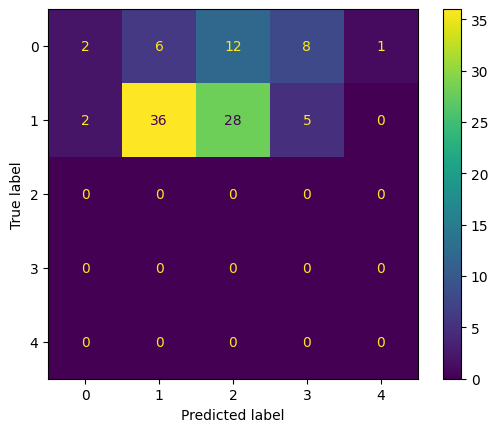

In [ ]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0,1,2,3,4])
cm_display.plot()
plt.show()

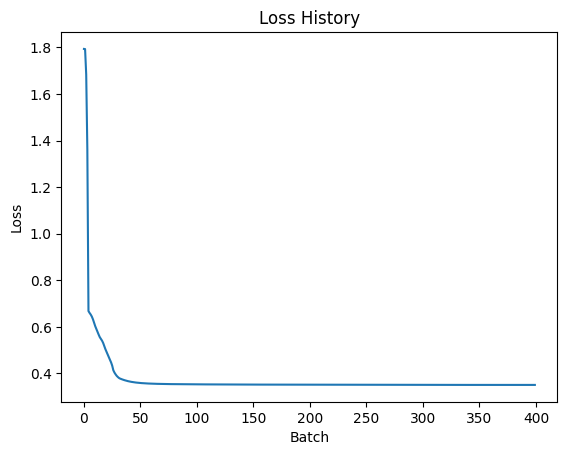

In [ ]:
loss_history = [x.item() for x in loss_history]
plt.plot(loss_history)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Loss History')
plt.show()